**케라스를 사용한 인공 신경망**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 퍼셉트론

In [2]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(int)
per_clf = Perceptron(n_jobs=-1)
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([0])

그림 저장: perceptron_iris_plot


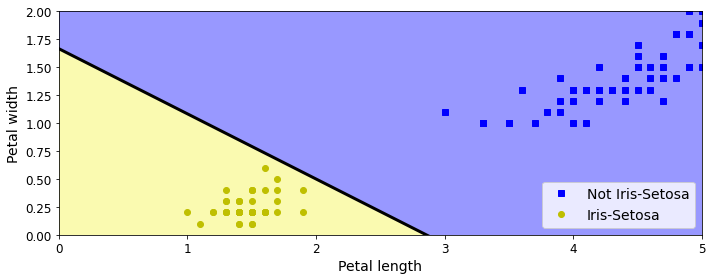

In [4]:
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1), np.linspace(axes[2], axes[3], 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
save_fig("perceptron_iris_plot")
plt.show()

# 활성화 함수

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

그림 저장: activation_functions_plot


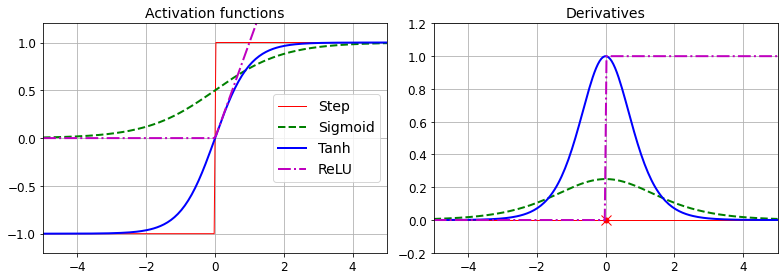

In [6]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])
plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)


def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

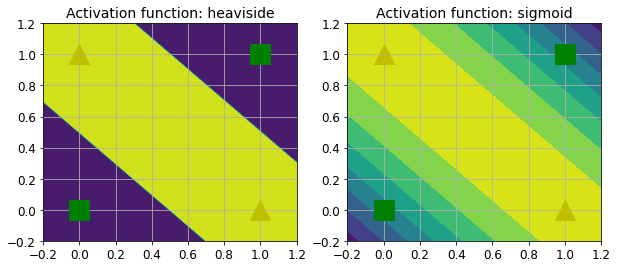

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)
z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# 이미지 분류기 만들기

먼저 텐서플로와 케라스를 임포트한다.

In [9]:
import tensorflow as tf

tf.__version__

'2.10.0'

In [10]:
from tensorflow import keras

keras.__version__

'2.10.0'

먼저 MNIST 데이터셋을 로드한다. 케라스는 `keras.datasets`에 널리 사용하는 데이터셋을 로드하기 위한 함수를 제공한다. 이 데이터셋은 이미 훈련 세트와 테스트 세트로 나누어져 있다. 훈련 세트를 더 나누어 검증 세트를 만드는 것이 좋다:

In [11]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

훈련 세트는 60,000개의 흑백 이미지이다. 각 이미지의 크기는 28x28 픽셀이다:

In [12]:
X_train_full.shape

(60000, 28, 28)

각 픽셀의 강도는 바이트(0~255)로 표현된다:

In [13]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (조금 더 작은) 훈련 세트로 나눈다. 또한 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꾼다.

In [14]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 `imshow()` 함수와 `'binary'` 컬러맵을 사용해 이미지를 출력한다:

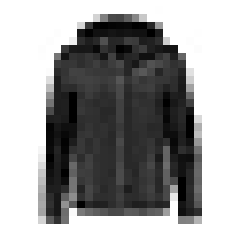

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

레이블은 0에서 9까지 (uint8로 표현된) 클래스 아이디이다:

In [16]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

클래스 이름은 다음과 같다:

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

훈련 세트에 있는 첫 번째 이미지는 코트이다:

In [18]:
class_names[y_train[0]]

'Coat'

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 가진다:

In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 샘플 이미지를 몇 개 출력해 본다:

그림 저장: fashion_mnist_plot


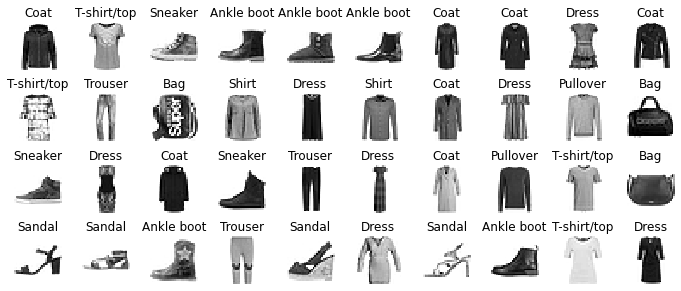

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_plot", tight_layout=False)
plt.show()

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
keras.backend.clear_session()

In [24]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [25]:
model.layers

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


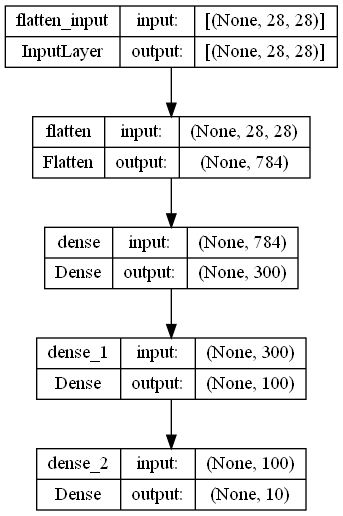

In [27]:
keras.utils.plot_model(model, os.path.join(IMAGES_PATH, "my_fashion_mnist_model.png"), show_shapes=True)

In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer(hidden1.name) is hidden1

True

In [30]:
weights, biases = hidden1.get_weights()

In [31]:
weights

array([[ 0.02855484, -0.02293003,  0.06947541, ..., -0.01129171,
         0.05193456,  0.00192127],
       [ 0.07357253,  0.00192686,  0.01178484, ...,  0.06612843,
        -0.0119172 , -0.04505606],
       [-0.00257169,  0.02813669, -0.00424178, ...,  0.02502371,
        -0.00422491,  0.0715386 ],
       ...,
       [ 0.03124021,  0.0609946 ,  0.06375632, ..., -0.05593554,
        -0.0692132 , -0.03207871],
       [ 0.01189919,  0.02633499, -0.06898526, ...,  0.05867326,
        -0.06785685,  0.01820853],
       [-0.00361652, -0.07102476,  0.01564573, ...,  0.00133476,
         0.06468777,  0.03604385]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

위 코드는 다음과 같다:

```python
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.SGD(),
    metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [36]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 3ms/step - loss: 0.7173 - accuracy: 0.7654 - val_loss: 0.4960 - val_accuracy: 0.8388
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4890 - accuracy: 0.8296 - val_loss: 0.4552 - val_accuracy: 0.8438
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4435 - accuracy: 0.8441 - val_loss: 0.4182 - val_accuracy: 0.8600
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4170 - accuracy: 0.8536 - val_loss: 0.4066 - val_accuracy: 0.8580
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3967 - accuracy: 0.8599 - val_loss: 0.3859 - val_accuracy: 0.8656
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3793 - accuracy: 0.8659 - val_loss: 0.3816 - val_accuracy: 0.8662
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3663 - accuracy: 0.8718 - val_loss: 0.3797 - val_accuracy:

In [37]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [38]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

그림 저장: keras_learning_curves_plot


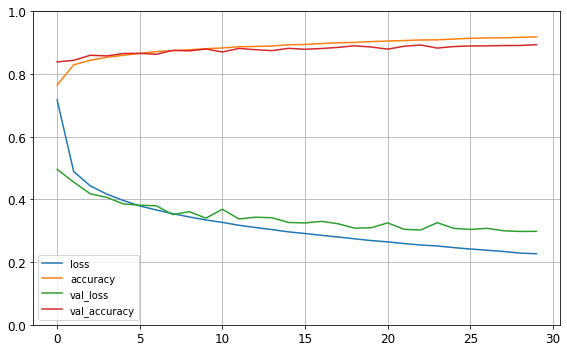

In [40]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [41]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3313 - accuracy: 0.8815


[0.33126142621040344, 0.8815000057220459]

In [42]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 81ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [43]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 22ms/step


array([9, 2, 1], dtype=int64)

In [44]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [45]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

그림 저장: fashion_mnist_images_plot


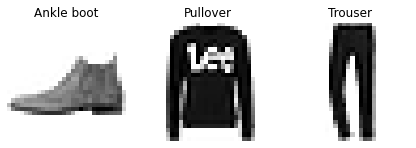

In [46]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_images_plot", tight_layout=False)
plt.show()

# 회귀 MLP

캘리포니아 주택 데이터셋을 로드하여 나누고 스케일을 바꾸어 본다:

In [47]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [48]:
model = keras.models.Sequential(
    [keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]), keras.layers.Dense(1)]
)
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 2.5861 - val_loss: 1.1181
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.8320 - val_loss: 0.6949
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6304 - val_loss: 0.6377
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5888 - val_loss: 0.6030
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5592 - val_loss: 0.5746
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5364 - val_loss: 0.5530
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5181 - val_loss: 0.5351
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5035 - val_loss: 0.5216
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4918 - val_loss: 0.5101
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4819 - val_loss: 0.5037

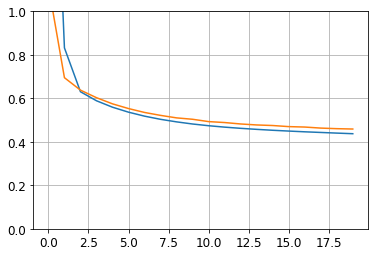

In [49]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [50]:
y_pred

array([[1.0761983],
       [2.4948058],
       [1.725791 ]], dtype=float32)

# 함수형 API

모든 신경망 모델이 단순하게 순서대로 나열되지는 않는다. 어떤 신경망은 매우 복잡한 구조를 가진다. 여러 개의 입력이 있거나 여러 개의 출력이 있다. 예를 들어 와이드 & 딥 신경망([논문](https://ai.google/research/pubs/pub45413) 참조)은 입력의 전체 또는 일부를 출력층에 바로 연결한다.

In [51]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [53]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.5802 - val_loss: 0.9245
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7565 - val_loss: 0.7428
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6749 - val_loss: 0.6963
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6341 - val_loss: 0.6494
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5994 - val_loss: 0.6201
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5731 - val_loss: 0.5960
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5531 - val_loss: 0.5670
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5352 - val_loss: 0.5529
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5215 - val_loss: 0.5354
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5090 - val_loss: 0.5292

In [54]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [55]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]
history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.2149 - val_loss: 0.9703
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7750 - val_loss: 0.7443
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6851 - val_loss: 0.6900
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6477 - val_loss: 0.6565
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6207 - val_loss: 0.6322
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5988 - val_loss: 0.6150
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5804 - val_loss: 0.5974
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5643 - val_loss: 0.5836
Epoch 9/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5502 - val_loss: 0.5678
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5378 - val_loss: 0.5545

규제를 위한 보조 출력 추가하기:

In [56]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [57]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [58]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

Epoch 1/20
363/363 [==============================] - 2s 6ms/step - loss: 2.5070 - main_output_loss: 2.2870 - aux_output_loss: 4.4876 - val_loss: 1.3017 - val_main_output_loss: 1.0421 - val_aux_output_loss: 3.6374
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.9837 - main_output_loss: 0.7771 - aux_output_loss: 2.8432 - val_loss: 0.9101 - val_main_output_loss: 0.7282 - val_aux_output_loss: 2.5465
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7847 - main_output_loss: 0.6419 - aux_output_loss: 2.0699 - val_loss: 0.7877 - val_main_output_loss: 0.6500 - val_aux_output_loss: 2.0271
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7085 - main_output_loss: 0.5988 - aux_output_loss: 1.6964 - val_loss: 0.7310 - val_main_output_loss: 0.6168 - val_aux_output_loss: 1.7590
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6667 - main_output_loss: 0.5737 - aux_output_loss: 1.5043 - val_loss

In [59]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 57ms/step


# 서브클래싱 API

In [60]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output


model = WideAndDeepModel(30, activation="relu")

In [61]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(
    (X_train_A, X_train_B), (y_train, y_train), epochs=10, validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid))
)
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 2.5354 - output_1_loss: 2.3108 - output_2_loss: 4.5562 - val_loss: 1.4372 - val_output_1_loss: 1.1399 - val_output_2_loss: 4.1133
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 1.1577 - output_1_loss: 0.9424 - output_2_loss: 3.0956 - val_loss: 1.0841 - val_output_1_loss: 0.8751 - val_output_2_loss: 2.9649
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.9437 - output_1_loss: 0.7961 - output_2_loss: 2.2715 - val_loss: 0.9363 - val_output_1_loss: 0.7785 - val_output_2_loss: 2.3565
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.8392 - output_1_loss: 0.7262 - output_2_loss: 1.8558 - val_loss: 0.8553 - val_output_1_loss: 0.7287 - val_output_2_loss: 1.9947
Epoch 5/10
363/363 [==============================] - 2s 5ms/step - loss: 0.7762 - output_1_loss: 0.6820 - output_2_loss: 1.6239 - val_loss: 0.7968 - val_output_1_loss: 0.6887 - val_ou

# 저장과 복원

In [62]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)

In [63]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.1959 - val_loss: 1.2112
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.9232 - val_loss: 0.7369
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6664 - val_loss: 0.6793
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6274 - val_loss: 0.6527
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6000 - val_loss: 0.6232
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5766 - val_loss: 0.5982
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5563 - val_loss: 0.5746
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5393 - val_loss: 0.5618
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5240 - val_loss: 0.5454
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4987


In [64]:
model.save("my_keras_model.h5")

In [65]:
model = keras.models.load_model("my_keras_model.h5")

In [66]:
model.predict(X_new)

1/1 [==============================] - 0s 47ms/step


array([[1.2515543],
       [2.3762748],
       [1.7598596]], dtype=float32)

In [67]:
model.save_weights("my_keras_weights.ckpt")

In [68]:
model.load_weights("my_keras_weights.ckpt")

# 훈련 과정에서 콜백 사용하기

In [69]:
keras.backend.clear_session()

In [70]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)

In [71]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5")  # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 2.6426 - val_loss: 0.9746
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.8167 - val_loss: 0.7601
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7121 - val_loss: 0.6964
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6628 - val_loss: 0.6592
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6280 - val_loss: 0.6318
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6011 - val_loss: 0.6042
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5786 - val_loss: 0.5842
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5601 - val_loss: 0.5658
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5438 - val_loss: 0.5541
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.5164


In [72]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb]
)
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5181 - val_loss: 0.5282
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5076 - val_loss: 0.5165
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4976 - val_loss: 0.5075
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4893 - val_loss: 0.5021
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4820 - val_loss: 0.4906
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4745 - val_loss: 0.4838
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4680 - val_loss: 0.4766
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4616 - val_loss: 0.4720
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4564 - val_loss: 0.4647
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4507 - val_lo

In [73]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: ", round(logs["val_loss"] / logs["loss"], 2))

In [74]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

359/363 [============================>.] - ETA: 0s - loss: 0.3458
val/train:  1.08
363/363 [==============================] - 1s 3ms/step - loss: 0.3458 - val_loss: 0.3721


# 텐서보드

In [75]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [76]:
import time


def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_09_26-13_35_49'

In [77]:
keras.backend.clear_session()

In [78]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [79]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb]
)

Epoch 1/30
363/363 [==============================] - 1s 3ms/step - loss: 1.9273 - val_loss: 1.0432
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.7778 - val_loss: 0.7132
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6555 - val_loss: 0.6507
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6062 - val_loss: 0.6134
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5704 - val_loss: 0.5792
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5427 - val_loss: 0.5534
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5204 - val_loss: 0.5373
Epoch 8/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5029 - val_loss: 0.5201
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4885 - val_loss: 0.5028
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4754 - val_loss: 0.4929

텐서보드 서버를 실행하는 한 가지 방법은 터미널에서 직접 실행하는 것이다. 터미널을 열고 텐서보드가 설치된 가상 환경을 활성화한다. 그다음 노트북 디렉토리로 이동하여 다음 명령을 입력한다:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

그다음 웹 브라우저를 열고 [localhost:6006](http://localhost:6006)에 접속하면 텐서보드를 사용할 수 있다. 사용이 끝나면 터미널에서 Ctrl-C를 눌러 텐서보드 서버를 종료한다.

또는 다음처럼 텐서보드의 주피터 확장을 사용할 수 있다(이 명령은 텐서보드가 로컬 컴퓨터에 설치되어 있어야 한다):

In [80]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2022_09_26-13_36_24'

In [81]:
keras.backend.clear_session()

In [82]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [83]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb]
)

Epoch 1/30
363/363 [==============================] - 2s 3ms/step - loss: 0.6300 - val_loss: 0.5217
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3980 - val_loss: 6.2417
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3961 - val_loss: 0.4490
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4121 - val_loss: 0.3786
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3633 - val_loss: 0.4197
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3514 - val_loss: 0.3661
Epoch 7/30
363/363 [==============================] - 1s 4ms/step - loss: 0.3368 - val_loss: 0.3566
Epoch 8/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3324 - val_loss: 0.3370
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3251 - val_loss: 0.3243
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3194 - val_loss: 0.3273

텐서보드에 실행 결과가 2개 있다. 학습 곡선을 비교해 본다.

사용할 수 있는 로깅 옵션을 확인해 본다:

In [84]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# 연습

## 1.

*심층 MLP를 MNIST 데이터셋에 훈련해 본다(`keras.datasets.mnist.load_data()` 함수를 사용해 데이터를 적재할 수 있다). 98% 이상의 정확도를 얻을 수 있는지 확인해 본다. 최적의 학습률을 찾아보자(즉 학습률을 지수적으로 증가시키면서 손실을 그래프로 그린다. 그다음 손실이 다시 증가하는 지점을 찾는다). 모든 부가 기능을 추가해 본다. 즉, 체크포인트를 저장하고, 조기 종료를 사용하고, 텐서보드를 사용해 학습 곡선을 그려 본다.*

데이터셋을 적재한다:

In [85]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


패션 MNIST 데이터셋처럼 MNIST 훈련 세트는 28x28 픽셀의 흑백 이미지 60,000개로 이루어져 있다:

In [86]:
X_train_full.shape

(60000, 28, 28)

각 픽셀 강도는 바이트(0~255)로 표현된다:

In [87]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (더 작은) 훈련 세트로 나누어 보자. 패션 MNIST처럼 픽셀 강도를 255로 나누어 0-1 범위의 실수로 변환한다:

In [88]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 `imshow()` 함수와 `'binary'` 컬러 맵으로 이미지를 출력해 본다:

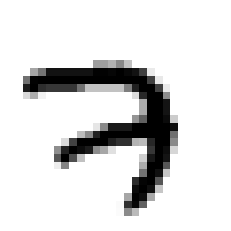

In [89]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

레이블은 (uint8로 표현된) 0에서 9까지 클래스 아이디이다. 편리하게도 클래스 아이디는 이미지가 나타내는 숫자와 같다. 따라서 `class_names` 배열을 만들 필요가 없다:

In [91]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 담고 있다:

In [93]:
X_valid.shape

(5000, 28, 28)

In [94]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 이미지 샘플 몇 개를 출력해 본다:

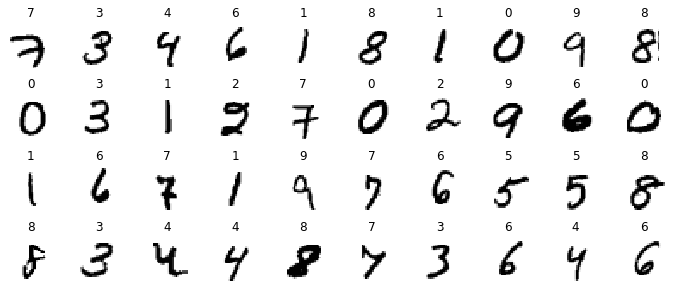

In [95]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

간단한 밀집 신경망을 만들고 최적의 학습률을 찾아 본다. 반복마다 학습률을 증가시키기 위해 콜백을 사용한다. 이 콜백은 반복마다 학습률과 손실을 기록한다:

In [96]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [97]:
keras.backend.clear_session()

In [98]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

작은 학습률 1e-3에서 시작하여 반복마다 0.5%씩 증가한다:

In [99]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)
expon_lr = ExponentialLearningRate(factor=1.005)

모델을 1 에포크만 훈련해 본다:

In [100]:
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[expon_lr])

1719/1719 [==============================] - 8s 4ms/step - loss: nan - accuracy: 0.5925 - val_loss: nan - val_accuracy: 0.0958


학습률에 대한 함수로 손실을 그릴 수 있다:

Text(0, 0.5, 'Loss')

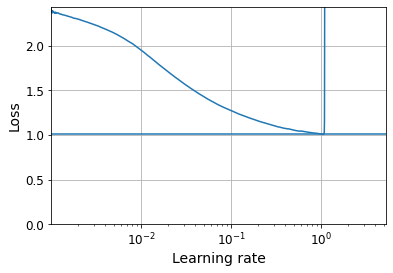

In [103]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

학습률이 6e-1을 지날 떄 손실이 갑자기 솟구치기 때문에 3e-1을 학습률로 사용하겠다:

In [115]:
keras.backend.clear_session()

In [116]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [117]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=3e-1), metrics=["accuracy"]
)

In [118]:
run_index = 1  # 실행할 때마다 이 값을 늘린다
run_logdir = os.path.join(os.curdir, "my_mnist_logs", f"run_{run_index:03d}")
run_logdir

'.\\my_mnist_logs\\run_001'

In [119]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb]
)

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2329 - accuracy: 0.9276 - val_loss: 0.1009 - val_accuracy: 0.9730
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0948 - accuracy: 0.9701 - val_loss: 0.1010 - val_accuracy: 0.9714
Epoch 3/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0654 - accuracy: 0.9785 - val_loss: 0.0834 - val_accuracy: 0.9730
Epoch 4/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.0728 - val_accuracy: 0.9796
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.0798 - val_accuracy: 0.9776
Epoch 6/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0825 - val_accuracy: 0.9772
Epoch 7/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0909 - val_ac

In [120]:
model = keras.models.load_model("my_mnist_model.h5")  # 최상의 모델로 롤백
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0818 - accuracy: 0.9766


[0.08176644891500473, 0.9765999913215637]

약 98% 정확도를 얻었다. 마지막으로 텐서보드를 사용해 학습 곡선을 살펴본다:

```bash
$ tensorboard --logdir=./my_mnist_logs --port=6007
```